This notebook will develop a procudure for defining a Froude number.


# Froude number

Griffin and Leblond (1990) used a Froude number to identify periods of high mixing. The Froude number is defined as

$Fr = \frac{u}{c} $

where $u$ is the speed of the ebb current and $c$ is an internal wave speed. If $Fr$ > 1 then the flow is supercritical ad large internal waves can form leading to increased mixing. When $Fr<1$ less mixing is expected. 

They used an internal wave speed based on a two-layer stratifiction defined as

$c = \sqrt{g\frac{\rho_2-\rho_1}{\rho_2}h_1}$

where $g$ is the accelaration due to gravity, $\rho_2$ is the density of the lower layer and $\rho_1$ and $h_1$ are the density and thickness of the upper layer.

PS. Is there a better way to define the wave speed?  
$c= \sqrt{g2\frac{\rho_2-\rho_1}{\rho_2+\rho_1}\frac{h_1h_2}{h_1+h_2}}$ (Helfrich and Melville, 2006)
Or is this more for internal solitary waves...


They found that $Fr<1$, is associated with pulses of fresh water at Race Rocks. This is because the fresh water exiting the Strait of Georgia through Haro Strait is less mixed when $Fr<1$. 

They describe neap tides as having a thicker surface layer and spring tides as having a thinner surface layer.

## froude.py
Modulde froude number and related calculations

#Model

Next, I will attempt to work out the parameters needed to define $Fr$ from our model results.

##Loading files

In [1]:
import netCDF4 as nc
import numpy as np
from salishsea_tools import nc_tools
import datetime
import os
import froude

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
path = '/data/nsoontie/MEOPAR/SalishSea/results/2Ddomain/3.6'
directory = 'density_output'
file_part = 'SalishSea_4h_20020915_20021012_{}.nc'

dT = nc.Dataset(os.path.join(path,directory,file_part.format('grid_T')))
sal = dT.variables['vosaline'][:]
sal = np.ma.masked_values(sal,0)
deps = dT.variables['deptht'][:]
temp = dT.variables['votemper'][:]
temp = np.ma.masked_values(temp,0)
ssh = dT.variables['sossheig'][:]
n2 = dT.variables['buoy_n2'][:]
n2 = np.ma.masked_values(n2,0)
times = dT.variables['time_counter'][:]
time_origin = datetime.datetime.strptime(dT.variables['time_counter'].time_origin, '%Y-%m-%d %H:%M:%S')
md = dT.variables['mixed_depth'][:]

dU = nc.Dataset(os.path.join(path,directory,file_part.format('grid_U')))
U = dU.variables['vozocrtx'][:]
U = np.ma.masked_values(U,0)
depsU=dU.variables['depthu'][:]

dW = nc.Dataset(os.path.join(path,directory,file_part.format('grid_W')))
avt = dW.variables['vert_eddy_diff'][:]
avt = np.ma.masked_values(avt,0)
avm = dW.variables['vert_eddy_visc'][:]
avm = np.ma.masked_values(avm,0)
depsW=dW.variables['depthw'][:]
diss = dW.variables['dissipation'][:]
diss = np.ma.masked_values(diss,0)


## $h_1$

We can use the buoyancy frequency to define the thickness of the surface layer. The surface layer should have a uniform stratification with depth which implies that the buoyancy frequency will be near zero in the surface layer.

So, we can define the $h_1$ as the first depth where the water column has buoyancy frequency greater than some small threshold. (threshold defintion)

We could also define $h_1$ as the depth were the buoyancy frequency is maximum. (max definition)

NEMO also has a way of defining the mixed layer depth based on the density deviation from a reference value.  We will compare those to methods here. (NEMO definition)

We can determine an average mixed layer depth by averaging over a region.


A spring tide

In [3]:
yslice=5
n2_slice = np.squeeze(n2[:,:,yslice,:])

('Average mld in sill region (threshold definition)', 5.4196663)


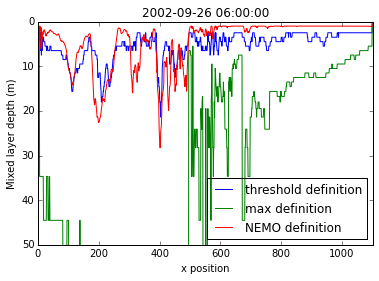

In [10]:
t=67
dinds =  froude.find_mixed_depth_indices(n2_slice[t,...])
dinds_max = froude.find_mixed_depth_indices(n2_slice[t,...],n2_thres='None')
plt.plot(deps[dinds],label='threshold definition')
plt.plot(deps[dinds_max],label='max definition')
plt.plot(md[t,yslice,:],label='NEMO definition')
plt.axis([0,1100,50,0])
plt.xlabel('x position')
plt.ylabel('Mixed layer depth (m)')
plt.title(time_origin+datetime.timedelta(seconds=times[t]))
plt.legend(loc=0)

print ('Average mld in sill region (threshold definition)', 
       froude.average_mixed_layer_depth(deps[dinds], 300, 700)
       )

Another spring tide

('Average mld in sill region (threshold definition)', 8.5245609)


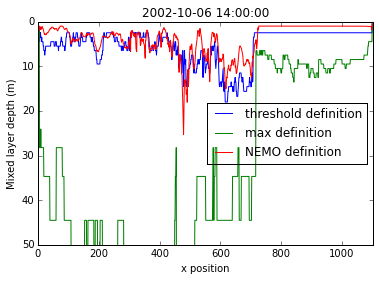

In [11]:

t=129
dinds =  froude.find_mixed_depth_indices(n2_slice[t,...])
dinds_max = froude.find_mixed_depth_indices(n2_slice[t,...],n2_thres='None')
plt.plot(deps[dinds],label='threshold definition')
plt.plot(deps[dinds_max],label='max definition')
plt.plot(md[t,yslice,:],label='NEMO definition')
plt.axis([0,1100,50,0])
plt.xlabel('x position')
plt.ylabel('Mixed layer depth (m)')
plt.title(time_origin+datetime.timedelta(seconds=times[t]))
plt.legend(loc=0)


print ('Average mld in sill region (threshold definition)', 
       froude.average_mixed_layer_depth(deps[dinds], 300, 700)
       )

A neap tide

('Average mld in sill region (threshold definition)', 6.6301107)


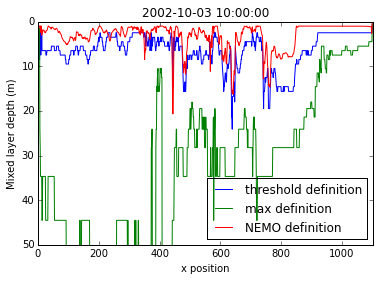

In [12]:
t=110
dinds =  froude.find_mixed_depth_indices(n2_slice[t,...])
dinds_max = froude.find_mixed_depth_indices(n2_slice[t,...],n2_thres='None')
plt.plot(deps[dinds],label='threshold definition')
plt.plot(deps[dinds_max],label='max definition')
plt.plot(md[t,yslice,:],label='NEMO definition')
plt.axis([0,1100,50,0])
plt.xlabel('x position')
plt.ylabel('Mixed layer depth (m)')
plt.title(time_origin+datetime.timedelta(seconds=times[t]))
plt.legend(loc=0)

print ('Average mld in sill region (threshold definition)', 
       froude.average_mixed_layer_depth(deps[dinds], 300, 700)
       )

My definition and the NEMO definition are not too far off. But NEMO always places the mld in the strongly stratified region closer to the surface. In general, my mld is lower than NEMO's. This might be because of the n2_thres.

Look at a time series of the mixed layer depth, averaged over the sill region.

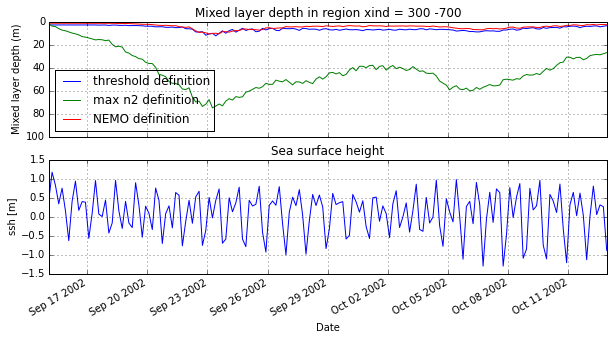

In [19]:
xmin=300; xmax=700
mlds, dates = froude.mld_time_series(n2_slice,deps,times, time_origin)
mlds_max, dates = froude.mld_time_series(n2_slice,deps,times, time_origin, n2_thres='None')
fig,axs=plt.subplots(2,1,figsize=((10,5)),sharex=True)
#mlds
ax=axs[0]
ax.plot(dates, mlds,label = 'threshold definition')
ax.plot(dates, mlds_max,label = 'max n2 definition')
#NEMO mixed layer
ax.plot(dates, np.mean(md[:,yslice,xmin:xmax+1],axis=1),label = 'NEMO definition')
ax.set_ylabel('Mixed layer depth (m)')
ax.set_title('Mixed layer depth in region xind = {} -{}'.format(xmin,xmax))
ax.set_ylim([100,0])
ax.grid()
ax.legend(loc=0)
#compare to tides
ax=axs[1]
ax.plot(dates,ssh[:,5,300])
ax.set_title('Sea surface height')
ax.set_ylabel('ssh [m]')
ax.set_xlabel('Date')
fig.autofmt_xdate()
ax.grid()

* There is an initial adjustment period until about Sept 23.
* There does seem to be a spring/neap dependency on the mixed layer depth
* Trend is that surface thickens just after the neap tide. Does that match with Griffin and Leblond? 
* Maybe this idea isn't the best way to determine the thickness of the surface layer. I'm assuming the surface layer is all on constant density - is that right? 
* Values seem reasonable. Griffin and Leblond quote 10 m in summer and 0 m in winter.
* Matches best with NEMO defintion mld is deeper (thicker surface layer). This looks to be just after the neap tide. 
* Remember, I don't think I have enough mixing here. But at least we are seeing a spring/neap cycle. 
* The max n2 definition seems to be a bit large.

###Sensitivity to n2_thres

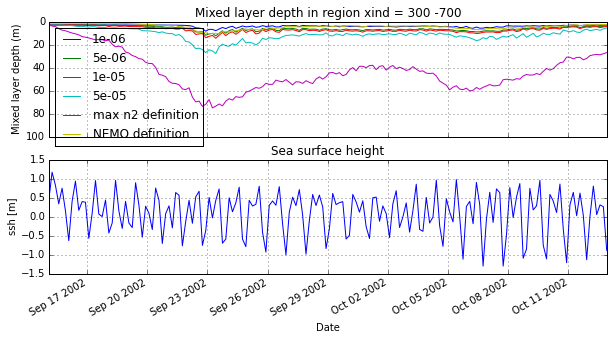

In [22]:
threshes = [1e-6, 5e-6, 1e-5, 5e-5]
xmin=300; xmax=700

fig,axs=plt.subplots(2,1,figsize=((10,5)),sharex=True)
ax=axs[0]
for thres in threshes:
    mlds, dates =froude.mld_time_series(n2_slice,deps,times, time_origin,n2_thres=thres)
    ax.plot(dates, mlds,label=thres)
#Max definition
mlds_max, dates =froude.mld_time_series(n2_slice,deps,times, time_origin,n2_thres='None')
ax.plot(dates, mlds_max,label='max n2 definition')
#NEMO definition
ax.plot(dates, np.mean(md[:,yslice,xmin:xmax+1],axis=1),label = 'NEMO definition')
#labels
ax.set_ylabel('Mixed layer depth (m)')
ax.set_title('Mixed layer depth in region xind = {} -{}'.format(xmin,xmax))
ax.set_ylim([100,0])
ax.grid()
ax.legend(loc=0)
#compare to tides
ax=axs[1]
ax.plot(dates,ssh[:,5,300])
ax.set_title('Sea surface height')
ax.set_ylabel('ssh [m]')
ax.set_xlabel('Date')
fig.autofmt_xdate()
ax.grid()

5e-6 or 1e-5 seem like reasonable choices for the n2 threshold. This matches with NEMO when the mld is deep. But, the match is worse for a shallower mixed layer. Why?

Maybe also compare with NEMO's calculation of the mixed layer depth.

#Density

Outputting the density didn't work. Use Susan's code that calculates density.

In [23]:
rho = froude.calculate_density(temp, sal)

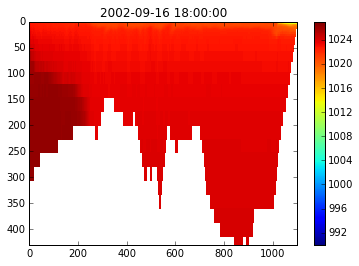

In [24]:
t=10
rhomin=990; rhomax=1027
plt.pcolormesh(np.arange(rho.shape[-1]),deps,rho[t,:,yslice,:],vmin=rhomin,vmax=rhomax)
plt.colorbar()
plt.axis([0,1100,430,0])
plt.title(time_origin+datetime.timedelta(seconds=times[t]))

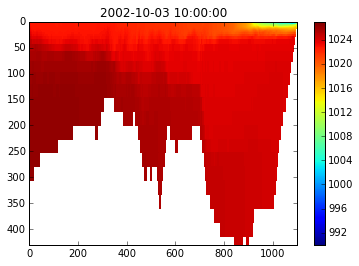

In [25]:
t=110
plt.pcolormesh(np.arange(rho.shape[-1]),deps,rho[t,:,yslice,:],vmin=rhomin,vmax=rhomax)
plt.colorbar()
plt.axis([0,1100,430,0])
plt.title(time_origin+datetime.timedelta(seconds=times[t]))

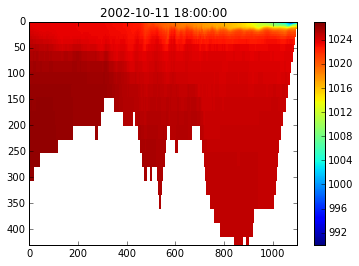

In [26]:
t=160
plt.pcolormesh(np.arange(rho.shape[-1]),deps,rho[t,:,yslice,:],vmin=rhomin,vmax=rhomax)
plt.colorbar()
plt.axis([0,1100,430,0])
plt.title(time_origin+datetime.timedelta(seconds=times[t]))

#Wave speed
Now, I am ready to define the wave speed.

* Density of upper layer = average above mld
* Density of lower layer = average below mld

/home/nsoontie/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


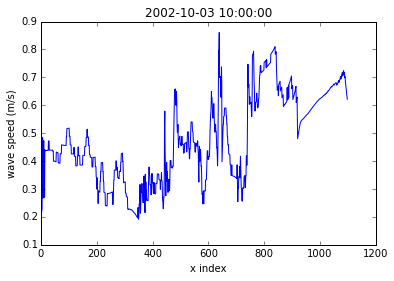

In [28]:
t = 110
dinds = froude.find_mixed_depth_indices(n2_slice[t,...])

c = froude.calculate_internal_wave_speed(rho[t,:,yslice,:],deps,dinds)

plt.plot(c)
plt.title(time_origin +datetime.timedelta(seconds=times[t]))
plt.ylabel('wave speed (m/s)')
plt.xlabel('x index')

These wave speeds seem reasonable. 

#Current Speed

How do I describe the current speed? My idea is to just take the depth averaged value.

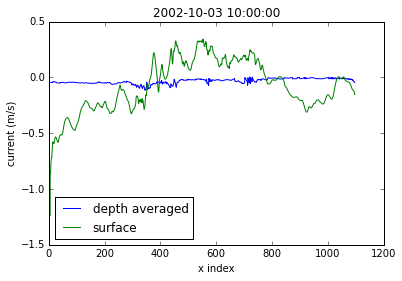

In [29]:
t = 110

u_avg = froude.depth_averaged_current(U[t,:,yslice,:],depsU)

plt.plot(u_avg,label='depth averaged')
plt.plot(U[t,0,yslice,:],label='surface')
plt.title(time_origin +datetime.timedelta(seconds=times[t]))
plt.ylabel('current (m/s)')
plt.xlabel('x index')
plt.legend(loc=0)

The depth averaged values are pretty small. Is the surface current a better choice?

Griffin and Leblond use a barotropic speed. But the also use they cube root mean cubed averaged over 25 hours.

#Froude number
Finally calculate the Froude number for a given time.

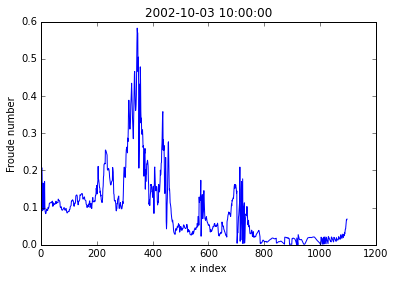

In [30]:
t = 110
n2_slice=n2[t,:,yslice,:]
rho_slice=rho[t,:,yslice,:]
u_slice=U[t,:,yslice,:]
Fr = froude.calculate_froude_number(n2_slice,rho_slice,u_slice,deps,depsU)

plt.plot(Fr)
plt.title(time_origin +datetime.timedelta(seconds=times[t]))
plt.ylabel('Froude number')
plt.xlabel('x index')


Mixing expected when Fr>1. At this time, this doens't happen. But this is also a neap tide. Let's look at time series, averaged over sill region.

In [32]:
n2_slice = n2[:,:,yslice,:]
rho_slice = rho[:,:,yslice,:]
u_slice = U[:,:,yslice,:]

Frs,dates = froude.froude_time_series(n2_slice,rho_slice,u_slice,deps,depsU,times,time_origin)
Frs_max,dates =froude.froude_time_series(n2_slice,rho_slice,u_slice,deps,depsU,times,time_origin,n2_thres='None')

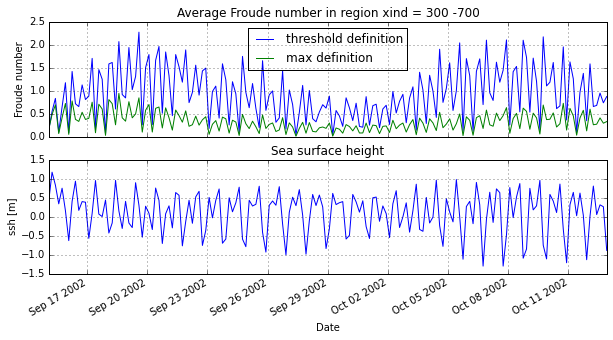

In [33]:
fig,axs = plt.subplots(2,1,figsize=(10,5),sharex=True)
ax=axs[0]
ax.plot(dates,Frs, label = 'threshold definition')
ax.plot(dates,Frs_max, label = 'max definition')
ax.set_ylabel('Froude number')
ax.set_title('Average Froude number in region xind = {} -{}'.format(xmin,xmax))
ax.set_ylim([0,2.5])
ax.grid()
ax.legend(loc=0)
#compare to tides
ax=axs[1]
ax.plot(dates,ssh[:,5,300])
ax.set_title('Sea surface height')
ax.set_ylabel('ssh [m]')
ax.set_xlabel('Date')
fig.autofmt_xdate()
ax.grid()

It looks to me like the Froude number matches the spring/neap cycle pretty well.

Using the max defintion, I never have Fr >1. Granted, I know there is not enough mixing in this model


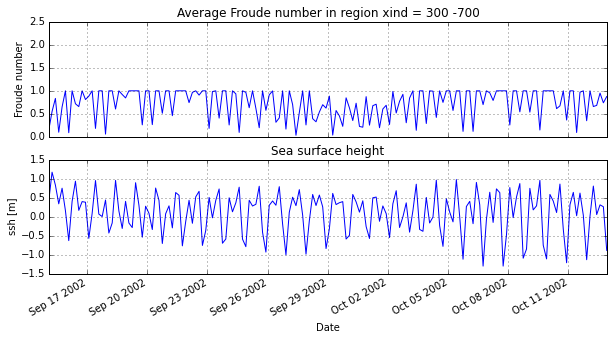

In [34]:
Fr_less_one = Frs*(np.array(Frs)<=1) +(np.array(Frs)>1)

fig,axs = plt.subplots(2,1,figsize=(10,5),sharex=True)
ax=axs[0]
ax.plot(dates,Fr_less_one)
ax.set_ylabel('Froude number')
ax.set_title('Average Froude number in region xind = {} -{}'.format(xmin,xmax))
ax.set_ylim([0,2.5])
ax.grid()
#compare to tides
ax=axs[1]
ax.plot(dates,ssh[:,5,300])
ax.set_title('Sea surface height')
ax.set_ylabel('ssh [m]')
ax.set_xlabel('Date')
fig.autofmt_xdate()
ax.grid()

It might be better to look at daily averages? I believe the high variability on day time scales is due to the daily tidal cycle. Griffin and Leblond use a 25 hour cubed root mean cubed barotropic tidal current.

#Next Steps

Compare Froude number between 2D and 3D simulations.

What I will need
* a way to calculaute buoyancy frequency. --> Look at NEMO's eosbn2.F90 module
* Comparable simulations --> run 2D over same time period and same averaging
* 25 hourly averaged currents?